In [29]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from radarseg.pytorch.focal_loss import focal_loss

In [31]:
def load_dataset():
    points_radar_with_anno = np.loadtxt('./radar_v1.0_mini.csv', delimiter=',')
    train_ratio = 0.8
    num_train = math.floor(points_radar_with_anno.shape[0] * train_ratio)
    # train data
    X_train_orig = points_radar_with_anno[:num_train, :18]
    Y_train_orig = points_radar_with_anno[:num_train, -1]
    Y_train_orig[Y_train_orig > 1] = 1
    # test data
    X_test_orig = points_radar_with_anno[num_train:, :18]
    Y_test_orig = points_radar_with_anno[num_train:, -1]
    Y_test_orig[Y_test_orig > 1] = 1
    print("Trainset ground ratio: ", 1.-1.*np.sum(Y_train_orig)/Y_train_orig.shape[0])
    print("Testset ground ratio: ", 1.-1.*np.sum(Y_test_orig)/Y_test_orig.shape[0])
    # to torch tensor
    X_train = torch.from_numpy(
        X_train_orig / np.max(X_train_orig, axis=1).reshape((-1, 1))).type(torch.FloatTensor) #
    X_test = torch.from_numpy(
        X_test_orig / np.max(X_test_orig, axis=1).reshape((-1, 1))).type(torch.FloatTensor) #
    Y_train = torch.from_numpy(Y_train_orig).type(torch.int64)
    Y_test = torch.from_numpy(Y_test_orig).type(torch.int64)
    print("X_train:", X_train.shape, X_train.dtype,)
    print("Y_train:", Y_train.shape, Y_train.dtype)
    print("X_test:", X_test.shape, X_test.dtype)
    print("Y_test:", Y_test.shape, Y_test.dtype)

    return X_train, Y_train, X_test, Y_test

In [32]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, n_hidden_1),
                                #  nn.BatchNorm1d(n_hidden_1),
                                 nn.ReLU(),
                                 nn.Linear(n_hidden_1, n_hidden_2),
                                #  nn.BatchNorm1d(n_hidden_2),
                                 nn.ReLU(),
                                 nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = self.net(x)
        return x

In [60]:
def train(args, model, device, train_loader, costs):
    # optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    # optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    # scheduler = StepLR(optimizer, step_size=20, gamma=args.gamma)
    # model.train()
    loss_fn = focal_loss(alpha=0.25, gamma=2, num_classes=2)
    for epoch in range(0, args.epochs+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            # loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        # scheduler.step()
        if epoch % args.log_interval == 0:
            print('Cost after Epoch {}: {:.6f}'.format(epoch, loss.item()))
        if epoch % 1 == 0: 
            costs.append(loss.item())

In [45]:
def test(args, model, device, data_loader):
    # 模型评估
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    print('Test Accuracy: {}/{} = {:.4f}'.format(
        correct, len(data_loader.dataset), 1. * correct / len(data_loader.dataset)))

In [46]:
# Loading the dataset
X_train, Y_train, X_test, Y_test = load_dataset()
# to DataLoader
trainset = Data.TensorDataset(X_train, Y_train)
testset = Data.TensorDataset(X_test, Y_test)

Trainset ground ratio:  0.8942906758877024
Testset ground ratio:  0.9404094564952474
X_train: torch.Size([131294, 18]) torch.float32
Y_train: torch.Size([131294]) torch.int64
X_test: torch.Size([32824, 18]) torch.float32
Y_test: torch.Size([32824]) torch.int64


batch_size:  512
epochs:  200
learing_rate:  0.0001
 --- Focal_loss alpha = 0.25 ,将对背景类进行衰减,请在目标检测任务中使用 --- 
Cost after Epoch 0: 0.052011
Cost after Epoch 100: 0.017620
Cost after Epoch 200: 0.018735


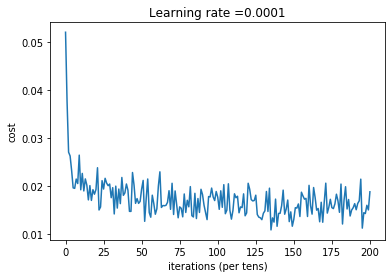

Test Accuracy: 119415/131294 = 0.9095
Test Accuracy: 30277/32824 = 0.9224


In [61]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
args = Namespace(
    batch_size=512, epochs=200, lr=0.0001, log_interval=100, 
    gamma=0.7, no_cuda=True, save_model=False, seed=1, test_batch_size=512)
print("batch_size: ", args.batch_size)
print("epochs: ", args.epochs)
print("learing_rate: ", args.lr)

torch.manual_seed(args.seed)

use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = Data.DataLoader(dataset=trainset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = Data.DataLoader(dataset=testset, batch_size=args.batch_size, shuffle=True, **kwargs)

model = Net(18, 9, 4, 2).to(device)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight, gain=1)
        m.bias.data.fill_(0.)
model.apply(init_weights)
costs = []
train(args, model, device, train_loader, costs)

# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(args.lr))
plt.show()

# eval
test(args, model, device, train_loader)
test(args, model, device, test_loader)

if args.save_model:
    torch.save(model.state_dict(), 'radarseg_v1.0_trainval.pt')